# Cosmologically Correct Horizon Distances

In [1]:
%%bash
lalapps_version

%% LAL: 6.15.2.1 (CLEAN 79d28921edfd3efdadd5eea260adf801a71becf9)
%% LALFrame: 1.3.0.1 (CLEAN 79d28921edfd3efdadd5eea260adf801a71becf9)
%% LALMetaIO: 1.2.6.1 (CLEAN 79d28921edfd3efdadd5eea260adf801a71becf9)
%% LALXML: 1.2.0.1 (CLEAN 79d28921edfd3efdadd5eea260adf801a71becf9)
%% LALSimulation: 1.4.1.1 (CLEAN 79d28921edfd3efdadd5eea260adf801a71becf9)
%% LALBurst: 1.4.0.1 (CLEAN 79d28921edfd3efdadd5eea260adf801a71becf9)
%% LALInspiral: 1.7.2.1 (CLEAN 79d28921edfd3efdadd5eea260adf801a71becf9)
%% LALPulsar: 1.12.0.1 (CLEAN 79d28921edfd3efdadd5eea260adf801a71becf9)
%% LALInference: 1.5.2.1 (CLEAN 79d28921edfd3efdadd5eea260adf801a71becf9)
%% LALStochastic: 1.1.16.1 (CLEAN 79d28921edfd3efdadd5eea260adf801a71becf9)
%% LALApps: 6.17.1.1 (CLEAN 79d28921edfd3efdadd5eea260adf801a71becf9)


## Astropy cosmology

Documentation at: http://docs.astropy.org/en/v0.2.1/cosmology/index.html

In [2]:
%matplotlib inline
from matplotlib import pyplot
import numpy

import astropy
print astropy.__version__
from astropy import cosmology

import lal, lalsimulation
from lalinference.rapid_pe import lalsimutils
from pylal.antenna import response

1.0.5


[]

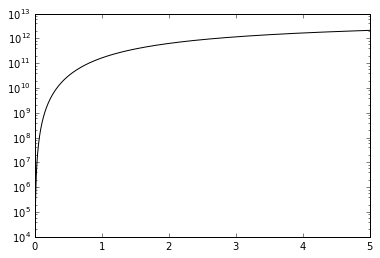

In [3]:
z_vals = numpy.linspace(0, 5, 1000)
dVdz = cosmology.Planck13.comoving_volume(z_vals).value

pyplot.plot(z_vals, dVdz, 'k-')
pyplot.semilogy()

## Power Spectral Densities

In [4]:
%%bash
wget https://losc.ligo.org/s/events/GW150914/P1500238/H1-GDS-CALIB_STRAIN.txt
wget https://losc.ligo.org/s/events/GW150914/P1500238/L1-GDS-CALIB_STRAIN.txt

--2016-05-02 10:24:42--  https://losc.ligo.org/s/events/GW150914/P1500238/H1-GDS-CALIB_STRAIN.txt
Resolving losc.ligo.org (losc.ligo.org)... 131.215.125.132
Connecting to losc.ligo.org (losc.ligo.org)|131.215.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3276850 (3.1M) [text/plain]
Saving to: ‘H1-GDS-CALIB_STRAIN.txt.3’

     0K .......... .......... .......... .......... ..........  1%  284K 11s
    50K .......... .......... .......... .......... ..........  3%  224K 12s
   100K .......... .......... .......... .......... ..........  4%  620K 10s
   150K .......... .......... .......... .......... ..........  6%  460K 9s
   200K .......... .......... .......... .......... ..........  7%  445K 8s
   250K .......... .......... .......... .......... ..........  9%  620K 8s
   300K .......... .......... .......... .......... .......... 10%  375K 7s
   350K .......... .......... .......... .......... .......... 12%  748K 7s
   400K .......... .......... 

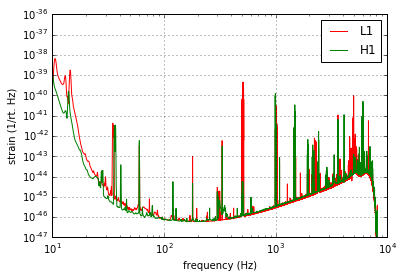

In [5]:
# Load PSDs
_, psd_l1 = numpy.loadtxt("L1-GDS-CALIB_STRAIN.txt", unpack=True)
freq, psd_h1 = numpy.loadtxt("H1-GDS-CALIB_STRAIN.txt", unpack=True)
df = freq[1]-freq[0]

psd_l1 *= psd_l1
psd_h1 *= psd_h1

pyplot.plot(freq, psd_l1, "r-", label="L1")
pyplot.plot(freq, psd_h1, "g-", label="H1")
pyplot.loglog()
pyplot.xlabel("frequency (Hz)")
pyplot.ylabel("strain (1/rt. Hz)")
pyplot.xlim(10, None)
pyplot.ylim(1e-47, None)
pyplot.grid()
pyplot.legend()

## 2018 Fully Advanced LIGO PSD

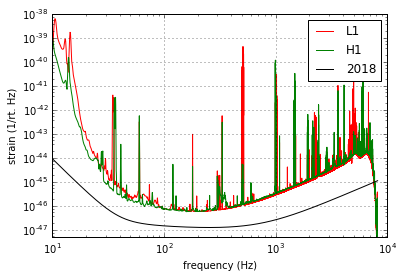

In [8]:
psd_2018 = map(lalsimulation.SimNoisePSDaLIGOZeroDetHighPower, freq)

pyplot.plot(freq, psd_l1, "r-", label="L1")
pyplot.plot(freq, psd_h1, "g-", label="H1")
pyplot.plot(freq, psd_2018, "k-", label="2018")
pyplot.loglog()
pyplot.xlabel("frequency (Hz)")
pyplot.ylabel("strain (1/rt. Hz)")
pyplot.xlim(10, None)
pyplot.ylim(.5e-47, 1e-38)
pyplot.grid()
pyplot.legend()

In [16]:
def get_waveform(z, mc, **kwargs):
    m1, m2 = lalsimutils.m1m2(mc, 0.25)
    m1, m2 = m1 * lal.MSUN_SI, m2 * lal.MSUN_SI
    s1x, s1y, s1z = 0.0, 0.0, 0.0
    s2x, s2y, s2z = 0.0, 0.0, 0.0
    approx = lalsimulation.GetApproximantFromString(kwargs["approx"] if "approx" in kwargs else "IMRPhenomD")
    distance = kwargs["distance"] * lal.PC_SI * 1e6
    
    hp, hx = lalsimulation.SimInspiralFD(0, df,
                                     m1, m2,
                                     s1x, s1y, s1z,
                                     s2x, s2y, s2z,
                                     30, 2048, 30,
                                     distance, z,
                                     numpy.pi, 0.0, 0.0,
                                     None, None, -1, 7, approx)
    return hp, hx

def snr(hp, hx, psd, **kwargs):
    ht = hp.data.data + hx.data.data
    f0_idx, flast_idx = int(numpy.round(hp.f0 / hp.deltaF)), len(ht)
    flast_idx += f0_idx
    return 2 * numpy.sqrt(numpy.real(ht*ht.conj()/psd[f0_idx:flast_idx]).sum())

#hp, hx = get_waveform(0, 28.0)
#print snr(hp, hx, psd_l1)
#print snr(hp, hx, psd_h1)

In [17]:
mc_min, mc_max = 0.8, 5
zmax = 0.5
def sample(n, fix_mc=None, vary_params=False):
    values = numpy.zeros((n, 3))
    distance = numpy.zeros(n)
    for i in range(n):
        #mc = numpy.random.uniform(9.5, 9.75) if fix_mc is None else fix_mc
        mc = numpy.random.uniform(mc_min, mc_max) if fix_mc is None else fix_mc
        z = numpy.random.uniform(0, zmax)
        dist = cosmology.Planck13.comoving_distance(z).value
        
        hp, hx = get_waveform(z, mc, distance=dist)
        
        if vary_params:
            ra, dec = numpy.random.uniform(0, 2*numpy.pi), numpy.random.uniform(-numpy.pi/2, numpy.pi/2)
            incl, psi = numpy.arccos(numpy.random.uniform(-1, 1)), numpy.random.uniform(0, 2*numpy.pi),
            fp, fx, _, _ = response(1e9, ra, dec, incl, psi, 'radians', 'L1')
            # FIXME, does second term need factor of 2?
            gp, gx = (1 + numpy.cos(incl)**2)**2/2, numpy.cos(incl)
            # FIXME: check if rotation by psi produces the same result
            hp.data.data *= fp * gp
            hx.data.data *= fx * gx
        
        h_snr = snr(hp, hx, psd_l1)
        #passthresh = 1 if h_snr > 8 else 0
        values[i] = (mc, z, h_snr)
        distance[i] = dist
        
    return values, distance

#zsamp, dist = sample(10000, fix_mc=30, vary_params=True)
zsamp, dist = sample(10000, vary_params=True)

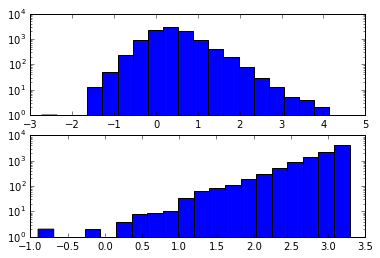

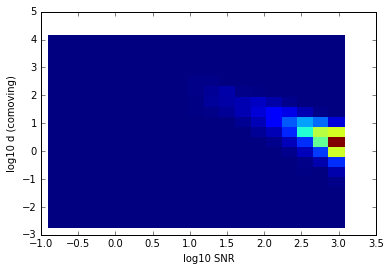

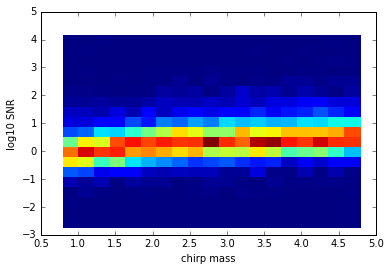

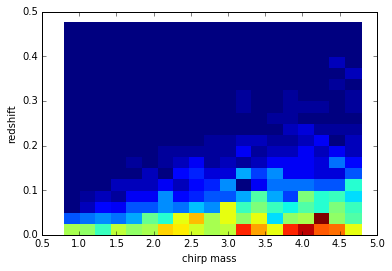

In [21]:
#h, bx, by = numpy.histogram2d(zsamp[:,0], zsamp[:,1], bins=20)
#pyplot.pcolor(bx[:-1], by[:-1], h)

weights = numpy.where(zsamp[:,2] > 8, numpy.ones(zsamp.shape[0]), numpy.zeros(zsamp.shape[0]))
pyplot.figure()
pyplot.subplot(2, 1, 1)
pyplot.hist(numpy.log10(zsamp[:,2]), bins=20, log=True)
pyplot.subplot(2, 1, 2)
pyplot.hist(numpy.log10(dist), bins=20, log=True)

# SNR vs comoving distance
pyplot.figure()
h, bx, by = numpy.histogram2d(numpy.log10(dist), numpy.log10(zsamp[:,2]), bins=20)
pyplot.pcolor(bx[:-1], by[:-1], h.T)
pyplot.xlabel("log10 SNR")
pyplot.ylabel("log10 d (comoving)")

# mchirp vs SNR
pyplot.figure()
h, bx, by = numpy.histogram2d(zsamp[:,0], numpy.log10(zsamp[:,2]), bins=20)
pyplot.pcolor(bx[:-1], by[:-1], h.T)
pyplot.xlabel("chirp mass")
pyplot.ylabel("log10 SNR")

# mchirp vs z
pyplot.figure()
h, bx, by = numpy.histogram2d(zsamp[:,0], zsamp[:,1], weights=weights, bins=20)
pyplot.pcolor(bx[:-1], by[:-1], h.T)
pyplot.xlabel("chirp mass")
pyplot.ylabel("redshift")
pyplot.savefig("mchirp_z.png")

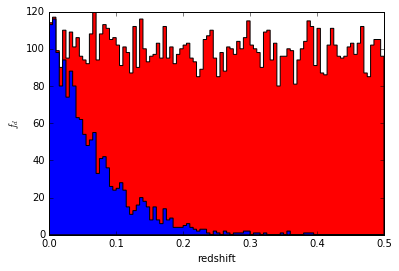

In [22]:
#zbins = numpy.logspace(-3, numpy.log10(2), 100, base=10)
denom, b, _ = pyplot.hist(zsamp[:,1], bins=100, color='r', histtype='stepfilled');
h, _, _ = pyplot.hist(zsamp[zsamp[:,2]>8,1], bins=b, color='b', histtype='stepfilled')
pyplot.xlabel("redshift")
pyplot.ylabel(r"$f_d$")
pyplot.savefig("fofz_z.png")

z_vals = b[1:] 
dz = b[1] - b[0]
z_vals += dz

f = h / denom.astype(float);

See Belczynski, et al. (2014) eqn. 5:

$$
\overline{V_c} = \int \frac{dV}{dz} \frac{1}{1+z} f_d(z) dz
$$

In [20]:
dVdz = cosmology.Planck13.comoving_volume(z_vals)
v_c = numpy.sum(dVdz / (1+z_vals) * f) * dz
d_c = (v_c * 3 / 4 / numpy.pi)**(1.0/3)

print v_c, d_c

27764283.925 Mpc3 187.844848435 Mpc
